# VQVAE Time Series Tokenization

Implementation of **TOTEM (Tokenized Time Series Embeddings)** for **Representation Learning for Carnatic Music Transcription**


In [1]:
import time
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from vqvae import vqvae

## Dataset

### Load dataset

In [2]:
with open('dataset/TRAIN.pkl', 'rb') as file:
    train_data = pickle.load(file)

with open('dataset/TEST.pkl', 'rb') as file:
    test_data = pickle.load(file)

### Normalize Time Series

Normalize pitch tracks such that the range from 0 to 1 spans **2 octaves**. 

In [3]:
X_train = train_data[:, 1] / 2400
X_test = test_data[:, 1] / 2400

### Pad and Truncate Sequences

The implementation expects both input and output lengths to be multiples of 4.  
Therefore, each time series is truncated to the nearest multiple of 4 **less than or equal to** `max_len`,  
and then **padded** (if necessary) to match `max_len`.

In [4]:
def pad_or_truncate(x, max_len):
    if len(x) > max_len:
        return x[:max_len]
    else:
        return np.pad(x, (0, max_len - len(x)), mode='constant', constant_values=x[-1])

### Create dataset loaders

In [3]:
max_len = max(len(x) for x in X_test)
max_len = max_len - (max_len % 4)

X_train = np.array([pad_or_truncate(x, max_len) for x in X_train])
X_test = np.array([pad_or_truncate(x, max_len) for x in X_test])

NameError: name 'X_test' is not defined

In [6]:
train_dataloader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True, num_workers=10, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(X_test, batch_size=64, shuffle=False, num_workers=10, drop_last=True)

## VQVAE

In [7]:
model = vqvae()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

### Train Loop

In [25]:
start_time = time.time()

for epoch in range(1001):
    model.train()
    epoch_loss = 0
    num_batches = 0
    for i, (batch) in enumerate(train_dataloader):
        batch = batch.to(dtype=torch.float, device=device)
    
        loss, vq_loss, recon_error, data_recon, perplexity, embedding_weight, encoding_indices, encodings = \
            model.shared_eval(batch, optimizer, 'train')
        
        epoch_loss += loss.item()
        num_batches += 1

    if epoch % 100 == 0:
        avg_epoch_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}: Loss = {avg_epoch_loss:.6f}")
    
    if epoch % 1000 == 0 and epoch != 0:
        torch.save(model, os.path.join(f'checkpoints/tokenizer_{epoch}.pth'))
        print('Saved model from epoch ', epoch)

print('total time: ', round(time.time() - start_time, 3))

Epoch 0: Loss = 0.000121
Epoch 100: Loss = 0.000103
Epoch 200: Loss = 0.000102
Epoch 300: Loss = 0.000100
Epoch 400: Loss = 0.000101
Epoch 500: Loss = 0.000101
Epoch 600: Loss = 0.000098
Epoch 700: Loss = 0.000100
Epoch 800: Loss = 0.000101
Epoch 900: Loss = 0.000101
total time:  1228.805


In [26]:
torch.save(model, os.path.join(f'checkpoints/model_1000.pth'))

In [27]:
model = torch.load('checkpoints/tokenizer_1000.pth', map_location=device, weights_only=False)

## Reconstruction Test

In [28]:
example_idx = [5, 10, 25, 40]

for batch in test_dataloader:
    batch = batch.to(dtype=torch.float, device=device)
    example_ori = batch[example_idx]
    
    loss, vq_loss, recon_error, data_recon, perplexity, embedding_weight, encoding_indices, encodings = \
                model.shared_eval(batch, optimizer, 'test')

    example_recon = data_recon[example_idx]

    z = model.encoder(batch)
    vq_loss, quantized, perplexity, embedding_weight, encoding_indices, encodings = model.vq(z)

    example_tokens = quantized[example_idx]
    
    break

### Original vs Reconstructed Time Series

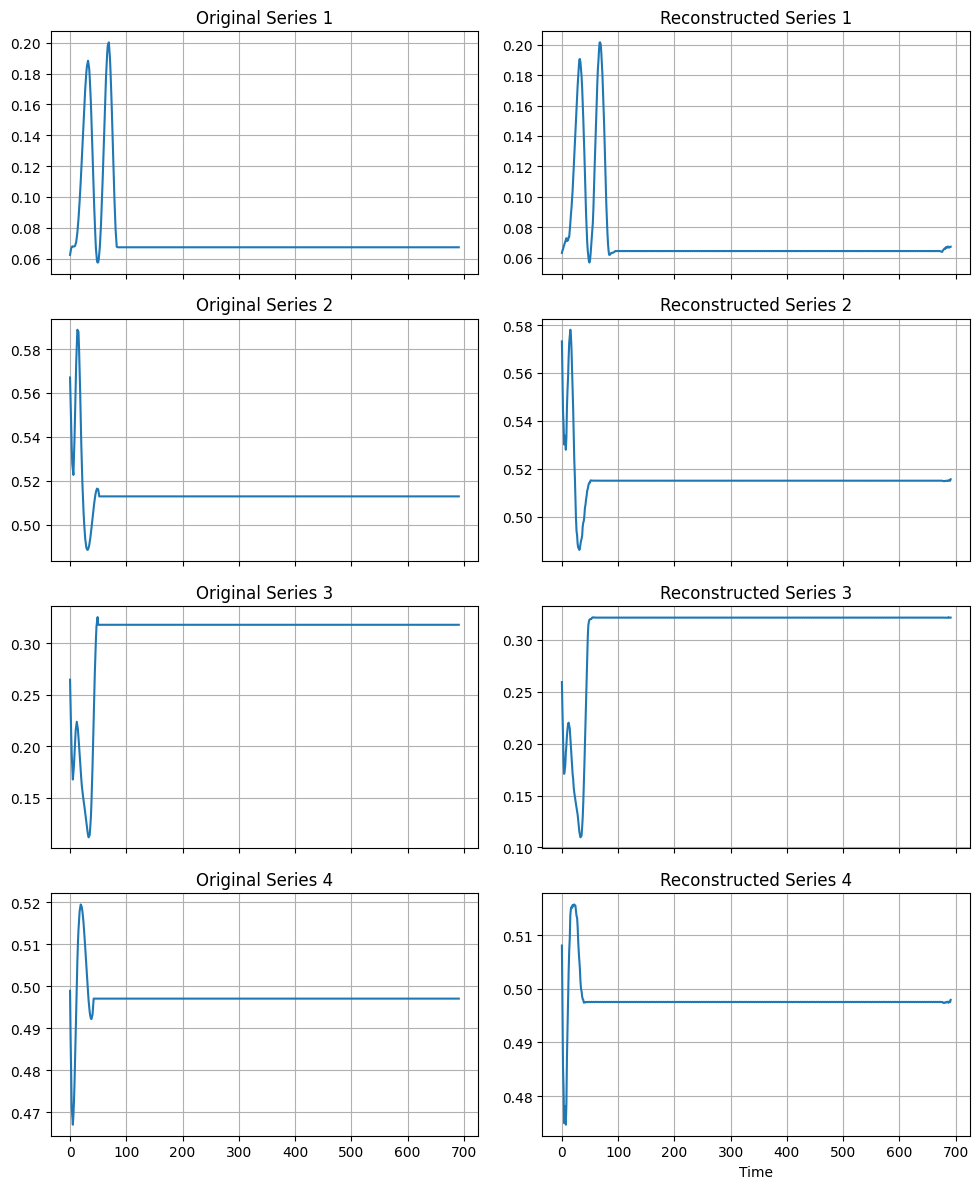

In [29]:
example_ori = example_ori.detach().cpu().numpy()
example_recon = example_recon.detach().cpu().numpy()

fig, axs = plt.subplots(4, 2, figsize=(10, 12), sharex='col')

for i in range(4):
    axs[i, 0].plot(example_ori[i])
    axs[i, 0].set_title(f"Original Series {i+1}")
    axs[i, 0].grid(True)

    axs[i, 1].plot(example_recon[i])
    axs[i, 1].set_title(f"Reconstructed Series {i+1}")
    axs[i, 1].grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.show()

### Quantized Tokens

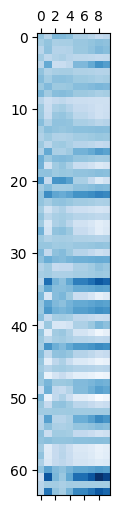

In [30]:
example_tokens = example_tokens.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.matshow(example_tokens[2][:,:10], cmap=plt.cm.Blues)

In [31]:
example_tokens[1]

array([[-0.17352681, -0.13137275, -0.17352681, ..., -0.15586098,
        -0.15586098, -0.15586098],
       [ 0.05531906,  0.03970989,  0.05531906, ...,  0.04885633,
         0.04885633,  0.04885633],
       [-0.23635265, -0.19914053, -0.23635265, ..., -0.2208002 ,
        -0.2208002 , -0.2208002 ],
       ...,
       [-1.6345803 , -1.2929571 , -1.6345803 , ..., -1.4913843 ,
        -1.4913843 , -1.4913843 ],
       [-0.36247534, -0.2982198 , -0.36247534, ..., -0.3354679 ,
        -0.3354679 , -0.3354679 ],
       [-0.60625774, -0.48547262, -0.60625774, ..., -0.55553955,
        -0.55553955, -0.55553955]], dtype=float32)

In [32]:
example_tokens[1].shape

(64, 173)